Purpose: Make PCA of TPM colored by LICOR data (photosynthetic/assimilation rate & stomatal conductance).<br>
Author: Anna Pardo<br>
Date initiated: Dec. 17, 2025

In [1]:
# load modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

## Section 1: Define functions

In [2]:
# define a function from an answer in https://stackoverflow.com/questions/39812885/retain-feature-names-after-scikit-feature-selection
def variance_threshold_selector(data):
    selector = VarianceThreshold()
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [3]:
# create a TPM data wrangling function - includes scaling
def tpm_prep(tpmmd):
    tpm = tpmmd.drop(["libid","genotype","time","treat","ZT","species","photo","cond"],axis=1).set_index("sample_name")
    vttpm = variance_threshold_selector(tpm)
    print("Number of zero-variance genes removed:",len(tpm.columns)-len(vttpm.columns))
    vttpm_log = vttpm.apply(lambda x: np.log2(x+1))
    scale = StandardScaler()
    vttpm_log_scaled = pd.DataFrame(scale.fit_transform(vttpm_log))
    return vttpm_log_scaled, vttpm_log

In [4]:
# PCA running function (first 6 PCs)
def run_pca(vttpm_log_scaled):
    pca = PCA(n_components=6)
    real_PCs = pca.fit_transform(vttpm_log_scaled)
    real_PCs_df = pd.DataFrame(data = real_PCs, columns = ['PC1','PC2','PC3','PC4','PC5','PC6'])
    print("Explained variance ratio:",pca.explained_variance_ratio_)
    return real_PCs_df

In [5]:
# Plot data formatting function
def make_plotdata(vttpm_log,tpmmd,pca):
    md = tpmmd[["sample_name","libid","genotype","time","treat","ZT","species","photo","cond"]]
    ltpm = vttpm_log.reset_index()
    ltpmmd = ltpm.merge(md)
    ordered_md = ltpmmd[["sample_name","libid","genotype","time","treat","ZT","species","photo","cond"]]
    plotdf = pd.concat([pca.reset_index(drop=True),ordered_md.reset_index(drop=True)],axis=1)
    return plotdf

In [6]:
# plotting function: by physiology
def plotpca_phys(plotdf,physcol,fname,pc1ev,pc2ev,pal,customtitle):
    ev1 = round(pc1ev*100,1)
    ev2 = round(pc2ev*100,1)
    
    pdfna = plotdf[plotdf[physcol].isna()].sort_values(by="treat",ascending=False)
    plotdf = plotdf.sort_values(by="treat",ascending=False)
    
    fig,ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(x=plotdf["PC1"],y=plotdf["PC2"],hue=plotdf[physcol],style=plotdf["treat"],palette=pal,s=75,alpha=0.75)
    sns.scatterplot(x=pdfna["PC1"],y=pdfna["PC2"],style=pdfna["treat"],color="gray",s=75,alpha=0.75)
    plt.legend(bbox_to_anchor=(1.01,1.01),fontsize=12)
    plt.xlabel("PC1 ("+str(ev1)+"%)",fontsize=16)
    plt.ylabel("PC2 ("+str(ev2)+"%)",fontsize=16)
    plt.title("PCA of logTPM by "+customtitle,fontsize=20)
    plt.savefig(fname+".png",dpi=200,bbox_inches="tight")
    plt.savefig(fname+".pdf",dpi=200,bbox_inches="tight")
    plt.savefig(fname+".svg",dpi=200,bbox_inches="tight")

## Section 2: Run & plot PCA 

In [7]:
# load TPM
## only samples with more than 1 million reads (850 total)
ygtpm = pd.read_csv("./TPM/Yg_toYgIS_allTPM_correctedmd_over1mil.txt",sep="\t",header="infer")

/tmp/ipykernel_7494/3743891475.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ygtpm = pd.read_csv("./TPM/Yg_toYgIS_allTPM_correctedmd_over1mil.txt",sep="\t",header="infer")


In [8]:
# load TPM with physiology data attached
phystpm = pd.read_csv("./TPM/TPM_photo_cond_772samp_17-Dec-2025.txt",sep="\t",header="infer")
phystpm.head()

/tmp/ipykernel_7494/2300543918.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  phystpm = pd.read_csv("./TPM/TPM_photo_cond_772samp_17-Dec-2025.txt",sep="\t",header="infer")


,sample_name,libid,genotype,time,treat,ZT,species,photo,cond,Yucal.07G108300.v2.1,...,YufilH1095122m.g,YufilH1095123m.g,YufilH1095125m.g,YufilH1095126m.g,YufilH1095128m.g,YufilH1095131m.g,YufilH1095132m.g,YufilH1095134m.g,YufilH1095146m.g,YufilH1095147m.g
0,Y1,Y1,18,1.0,W,1.0,gloriosa,5.223603,0.067530,47.645585,...,0.000000,6.167441,1.435253,0.279077,11.420139,0.662252,1.886709,6.675105,0.0,0.000000
1,Y10,Y10,2AB,1.5,W,3.0,gloriosa,4.499417,0.061857,39.612085,...,0.713535,2.197522,15.695904,1.193256,10.172780,0.000000,2.214483,12.125756,0.0,0.000000
2,Y100,Y100,2AB,6.5,W,23.0,gloriosa,0.721814,0.010483,37.101730,...,0.314746,2.261806,21.742515,1.798380,10.256681,1.748663,2.075757,25.215640,0.0,1.838780
3,Y101,Y101,2AB,1.0,D,1.0,gloriosa,1.556074,0.016346,32.852926,...,0.000000,1.072366,27.573939,1.164591,9.105769,1.257431,2.431447,4.508369,0.0,0.813682
4,Y103,Y103,2AB,1.0,D,1.0,gloriosa,1.029948,0.015640,53.977262,...,0.000000,0.914550,28.621412,0.869052,7.076224,0.515567,2.419222,4.625880,0.0,0.867418


In [9]:
ygtpm.head()

,sample_name,genotype,time,treat,ZT,species,Yucal.01G000100.v2.1,Yucal.01G000200.v2.1,Yucal.01G000300.v2.1,Yucal.01G000400.v2.1,...,YufilH1095122m.g,YufilH1095123m.g,YufilH1095125m.g,YufilH1095126m.g,YufilH1095128m.g,YufilH1095131m.g,YufilH1095132m.g,YufilH1095134m.g,YufilH1095146m.g,YufilH1095147m.g
0,Y1,18,1.0,W,1.0,gloriosa,34.002815,4.546167,0.0,17.236119,...,0.000000,6.167441,1.435253,0.279077,11.420139,0.662252,1.886709,6.675105,0.0,0.000000
1,Y10,2AB,1.5,W,3.0,gloriosa,40.070758,3.628454,0.0,14.918115,...,0.713535,2.197522,15.695904,1.193256,10.172780,0.000000,2.214483,12.125756,0.0,0.000000
2,Y100,2AB,6.5,W,23.0,gloriosa,47.402599,5.201760,0.0,17.406497,...,0.314746,2.261806,21.742515,1.798380,10.256681,1.748663,2.075757,25.215640,0.0,1.838780
3,Y101,2AB,1.0,D,1.0,gloriosa,57.062380,6.374324,0.0,10.567561,...,0.000000,1.072366,27.573939,1.164591,9.105769,1.257431,2.431447,4.508369,0.0,0.813682
4,Y103,2AB,1.0,D,1.0,gloriosa,34.679279,6.087451,0.0,11.115252,...,0.000000,0.914550,28.621412,0.869052,7.076224,0.515567,2.419222,4.625880,0.0,0.867418


In [9]:
# combine the data
## to do so, make some new columns in ygtpm
ygtpm["photo"] = np.nan
ygtpm["cond"] = np.nan
ygtpm["libid"] = ygtpm["sample_name"]
ygtpm.head()

,sample_name,genotype,time,treat,ZT,species,Yucal.01G000100.v2.1,Yucal.01G000200.v2.1,Yucal.01G000300.v2.1,Yucal.01G000400.v2.1,...,YufilH1095126m.g,YufilH1095128m.g,YufilH1095131m.g,YufilH1095132m.g,YufilH1095134m.g,YufilH1095146m.g,YufilH1095147m.g,photo,cond,libid
0,Y1,18,1.0,W,1.0,gloriosa,34.002815,4.546167,0.0,17.236119,...,0.279077,11.420139,0.662252,1.886709,6.675105,0.0,0.000000,NaN,NaN,Y1
1,Y10,2AB,1.5,W,3.0,gloriosa,40.070758,3.628454,0.0,14.918115,...,1.193256,10.172780,0.000000,2.214483,12.125756,0.0,0.000000,NaN,NaN,Y10
2,Y100,2AB,6.5,W,23.0,gloriosa,47.402599,5.201760,0.0,17.406497,...,1.798380,10.256681,1.748663,2.075757,25.215640,0.0,1.838780,NaN,NaN,Y100
3,Y101,2AB,1.0,D,1.0,gloriosa,57.062380,6.374324,0.0,10.567561,...,1.164591,9.105769,1.257431,2.431447,4.508369,0.0,0.813682,NaN,NaN,Y101
4,Y103,2AB,1.0,D,1.0,gloriosa,34.679279,6.087451,0.0,11.115252,...,0.869052,7.076224,0.515567,2.419222,4.625880,0.0,0.867418,NaN,NaN,Y103


In [11]:
phystpm.head()

,sample_name,libid,genotype,time,treat,ZT,species,photo,cond,Yucal.07G108300.v2.1,...,YufilH1095122m.g,YufilH1095123m.g,YufilH1095125m.g,YufilH1095126m.g,YufilH1095128m.g,YufilH1095131m.g,YufilH1095132m.g,YufilH1095134m.g,YufilH1095146m.g,YufilH1095147m.g
0,Y1,Y1,18,1.0,W,1.0,gloriosa,5.223603,0.067530,47.645585,...,0.000000,6.167441,1.435253,0.279077,11.420139,0.662252,1.886709,6.675105,0.0,0.000000
1,Y10,Y10,2AB,1.5,W,3.0,gloriosa,4.499417,0.061857,39.612085,...,0.713535,2.197522,15.695904,1.193256,10.172780,0.000000,2.214483,12.125756,0.0,0.000000
2,Y100,Y100,2AB,6.5,W,23.0,gloriosa,0.721814,0.010483,37.101730,...,0.314746,2.261806,21.742515,1.798380,10.256681,1.748663,2.075757,25.215640,0.0,1.838780
3,Y101,Y101,2AB,1.0,D,1.0,gloriosa,1.556074,0.016346,32.852926,...,0.000000,1.072366,27.573939,1.164591,9.105769,1.257431,2.431447,4.508369,0.0,0.813682
4,Y103,Y103,2AB,1.0,D,1.0,gloriosa,1.029948,0.015640,53.977262,...,0.000000,0.914550,28.621412,0.869052,7.076224,0.515567,2.419222,4.625880,0.0,0.867418


In [10]:
# reorder ygtpm 
gidslist = ["Yucal.07G108300.v2.1"]
for c in ygtpm.columns:
    if c.startswith("Y"):
        if c not in gidslist:
            gidslist.append(c)
    

In [11]:
ygtpm = ygtpm[["sample_name","libid","genotype","time","treat","ZT","species","photo","cond"]+gidslist]

In [12]:
subtpm = ygtpm[~ygtpm["sample_name"].isin(list(phystpm["sample_name"]))]

In [13]:
len(subtpm.index)

80

In [14]:
len(ygtpm["sample_name"].unique())-len(phystpm["sample_name"].unique())

80

In [15]:
len(ygtpm.index)==len(ygtpm["sample_name"].unique())

True

In [16]:
len(phystpm.drop_duplicates().index)==len(phystpm["sample_name"].unique())

True

In [17]:
phystpm = phystpm.drop_duplicates()

In [18]:
totaltpm = pd.concat([phystpm,subtpm])

In [19]:
len(phystpm.index)

770

In [20]:
totaltpm.to_csv("./TPM/TPM_phys770_nonphys80_17-Dec-2025.txt",sep="\t",header=True,index=False)

In [21]:
len(totaltpm.index)

850

In [21]:
totaltpm.head()

,sample_name,libid,genotype,time,treat,ZT,species,photo,cond,Yucal.07G108300.v2.1,...,YufilH1095122m.g,YufilH1095123m.g,YufilH1095125m.g,YufilH1095126m.g,YufilH1095128m.g,YufilH1095131m.g,YufilH1095132m.g,YufilH1095134m.g,YufilH1095146m.g,YufilH1095147m.g
0,Y1,Y1,18,1.0,W,1.0,gloriosa,5.223603,0.067530,47.645585,...,0.000000,6.167441,1.435253,0.279077,11.420139,0.662252,1.886709,6.675105,0.0,0.000000
1,Y10,Y10,2AB,1.5,W,3.0,gloriosa,4.499417,0.061857,39.612085,...,0.713535,2.197522,15.695904,1.193256,10.172780,0.000000,2.214483,12.125756,0.0,0.000000
2,Y100,Y100,2AB,6.5,W,23.0,gloriosa,0.721814,0.010483,37.101730,...,0.314746,2.261806,21.742515,1.798380,10.256681,1.748663,2.075757,25.215640,0.0,1.838780
3,Y101,Y101,2AB,1.0,D,1.0,gloriosa,1.556074,0.016346,32.852926,...,0.000000,1.072366,27.573939,1.164591,9.105769,1.257431,2.431447,4.508369,0.0,0.813682
4,Y103,Y103,2AB,1.0,D,1.0,gloriosa,1.029948,0.015640,53.977262,...,0.000000,0.914550,28.621412,0.869052,7.076224,0.515567,2.419222,4.625880,0.0,0.867418


In [7]:
# reload totaltpm
totaltpm = pd.read_csv("./TPM/TPM_phys770_nonphys80_17-Dec-2025.txt",sep="\t",header="infer")

/tmp/ipykernel_111/1537527818.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  totaltpm = pd.read_csv("./TPM/TPM_phys770_nonphys80_17-Dec-2025.txt",sep="\t",header="infer")


In [8]:
vtyg_log_scaled, vtyg_log = tpm_prep(totaltpm)
vtyg_log_scaled.head()

Number of zero-variance genes removed: 1632


,0,1,2,3,4,5,6,7,8,9,...,84320,84321,84322,84323,84324,84325,84326,84327,84328,84329
0,-0.592241,0.348880,-0.834954,-0.334001,1.439502,1.058610,0.597207,0.866895,-0.146352,-0.622954,...,0.509444,-0.389983,0.505750,-1.181594,-0.992145,1.281659,-1.435665,-0.209007,-0.180784,-0.862790
1,-0.773023,0.729794,-1.454285,-0.334001,0.934510,-1.006967,-1.829420,-0.228190,-0.146352,-1.394524,...,2.402372,4.396797,-1.274647,0.639196,0.300767,0.871177,-2.129734,0.186032,1.046263,-0.862790
2,-0.836930,1.121166,-0.452414,-0.334001,1.474046,-0.321338,0.135712,2.197569,-0.146352,0.483551,...,1.053028,2.042199,-1.230743,0.931520,0.884956,0.900193,-0.748742,0.023992,2.628176,1.007239
3,-0.955351,1.554729,0.140509,-0.334001,-0.251400,0.771591,1.286564,0.428850,-0.146352,-1.400973,...,0.606190,-0.389983,-2.231235,1.147409,0.269225,0.481889,-1.017653,0.425943,-0.939322,0.204265
4,-0.469688,0.394488,0.004654,-0.334001,-0.079559,0.845327,0.797885,0.081903,-0.146352,-1.223490,...,0.207223,-0.389983,-2.405948,1.181461,-0.082746,-0.387573,-1.561844,0.412833,-0.891052,0.256597


In [9]:
pca_yg = run_pca(vtyg_log_scaled)

Explained variance ratio: [0.12703223 0.06629084 0.05858518 0.04585696 0.03641326 0.03190001]


In [10]:
plot_yg = make_plotdata(vtyg_log,totaltpm,pca_yg)
plot_yg.head()

,PC1,PC2,PC3,PC4,PC5,PC6,sample_name,libid,genotype,time,treat,ZT,species,photo,cond
0,-6.708725,-5.249459,-49.895862,138.401644,4.875554,-28.664250,Y1,Y1,18,1.0,W,1.0,gloriosa,5.223603,0.067530
1,70.907648,145.325770,-21.456285,68.250933,-26.233916,-58.141182,Y10,Y10,2AB,1.5,W,3.0,gloriosa,4.499417,0.061857
2,-133.086681,114.346169,71.767470,59.470282,0.311378,-15.596523,Y100,Y100,2AB,6.5,W,23.0,gloriosa,0.721814,0.010483
3,24.135755,144.562424,13.371666,108.838817,-24.394496,46.121708,Y101,Y101,2AB,1.0,D,1.0,gloriosa,1.556074,0.016346
4,55.076889,134.004332,24.346542,100.051053,-22.837312,54.166521,Y103,Y103,2AB,1.0,D,1.0,gloriosa,1.029948,0.015640


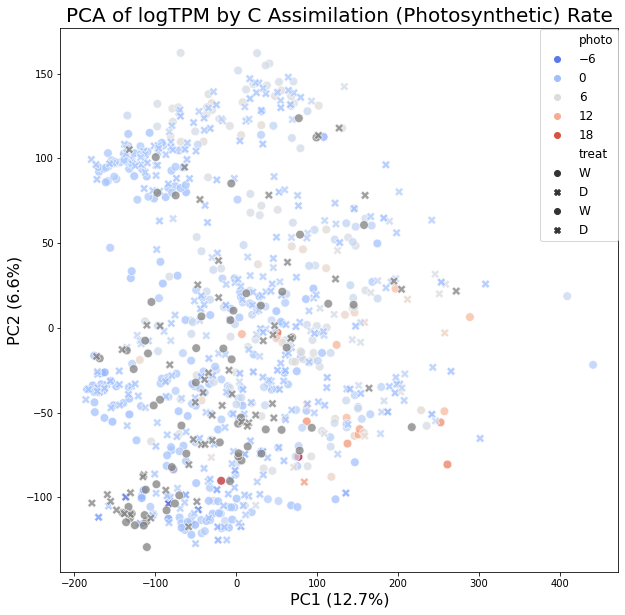

In [11]:
plotpca_phys(plotdf=plot_yg,physcol="photo",fname="./pca_plots/pca_by_licorphoto",pc1ev=0.12703223,
             pc2ev=0.06629084,pal="coolwarm",customtitle="C Assimilation (Photosynthetic) Rate")

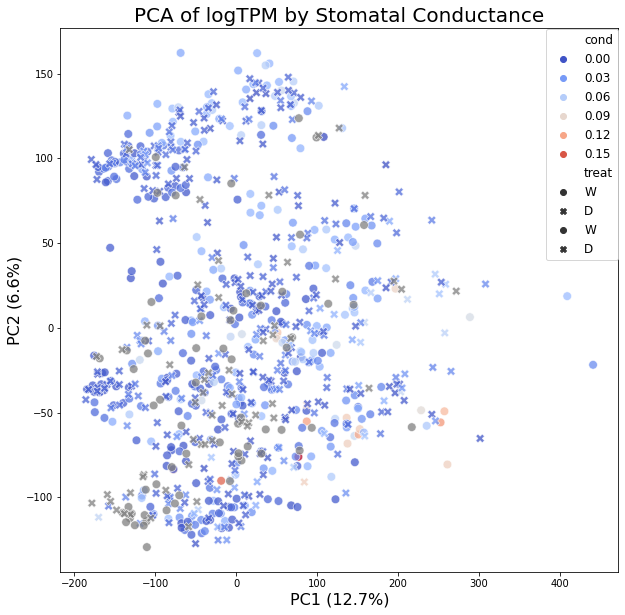

In [12]:
plotpca_phys(plotdf=plot_yg,physcol="cond",fname="./pca_plots/pca_by_licorcond",pc1ev=0.12703223,
             pc2ev=0.06629084,pal="coolwarm",customtitle="Stomatal Conductance")